In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as nnf
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import Dataset

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torchinfo import summary

from utils.datasets import CIFAR_SR

from tqdm import tqdm

import matplotlib.pyplot as plt

from models.prediction.VAE import VAE

from utils.metrics import validation_scores

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
path = "CIFAR_VAE_divers.pth"

x_dim = 32

scale_factor = 4
x_inp_dim  = int(x_dim / scale_factor)

# lr = 1e-3
epochs = 300
batch_size = 1024
batch_size_test = 128

train_dataset = CIFAR_SR(split="train", scale_factor=scale_factor)
test_dataset = CIFAR_SR(split="test", scale_factor=scale_factor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [3]:
in_channels = 3
channels = [32, 64, 128, 256]
latent_dims = [80]

model = VAE(in_channels=in_channels, channels=channels, latent_dims=latent_dims, base_width=x_inp_dim).to(DEVICE)
summary(model, input_size=(1,in_channels, x_inp_dim, x_inp_dim))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 3, 32, 32]            --
├─VAELREncoder: 1-1                      [1, 80]                   --
│    └─Conv2d: 2-1                       [1, 32, 8, 8]             128
│    └─Conv2d: 2-2                       [1, 64, 4, 4]             32,832
│    └─Conv2d: 2-3                       [1, 128, 2, 2]            131,200
│    └─Linear: 2-4                       [1, 80]                   41,040
│    └─Linear: 2-5                       [1, 80]                   41,040
├─VAEDecoder: 1-2                        [1, 3, 32, 32]            --
│    └─Linear: 2-6                       [1, 4096]                 331,776
│    └─ConvTranspose2d: 2-7              [1, 128, 8, 8]            524,416
│    └─ConvTranspose2d: 2-8              [1, 64, 16, 16]           131,136
│    └─ConvTranspose2d: 2-9              [1, 32, 32, 32]           32,800
│    └─Conv2d: 2-10                      [1, 3, 

In [4]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return (reproduction_loss + KLD) / x.size(0)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

In [5]:
model_loss = []

In [6]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        HR, LR = batch

        SR, latents = model(LR)
        mean, log_var = latents[0]
        loss = loss_function(HR, SR, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("\tEpoch", epoch, "complete!", "\tAverage Loss: ", overall_loss)

    model_loss.append(overall_loss)
    scheduler.step(overall_loss)

print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss)
print("Finish!!")

Start training VAE...
	Epoch 0 complete! 	Average Loss:  101324.96264648438


c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


	Epoch 10 complete! 	Average Loss:  98201.03454589844
	Epoch 20 complete! 	Average Loss:  98201.04577636719
	Epoch 30 complete! 	Average Loss:  98201.03588867188
	Epoch 40 complete! 	Average Loss:  98199.95385742188
	Epoch 50 complete! 	Average Loss:  98204.52124023438
	Epoch 60 complete! 	Average Loss:  98203.10083007812
	Epoch 70 complete! 	Average Loss:  98202.75598144531
	Epoch 80 complete! 	Average Loss:  98204.68029785156
	Epoch 90 complete! 	Average Loss:  98200.04833984375
	Epoch 100 complete! 	Average Loss:  98202.47619628906
	Epoch 110 complete! 	Average Loss:  98202.01879882812
	Epoch 120 complete! 	Average Loss:  98201.48095703125
	Epoch 130 complete! 	Average Loss:  98202.74365234375
	Epoch 140 complete! 	Average Loss:  98202.91320800781
	Epoch 150 complete! 	Average Loss:  98205.11682128906
	Epoch 160 complete! 	Average Loss:  98201.09375
	Epoch 170 complete! 	Average Loss:  98198.90270996094
	Epoch 180 complete! 	Average Loss:  98203.09741210938
	Epoch 190 complete! 	Ave

[]

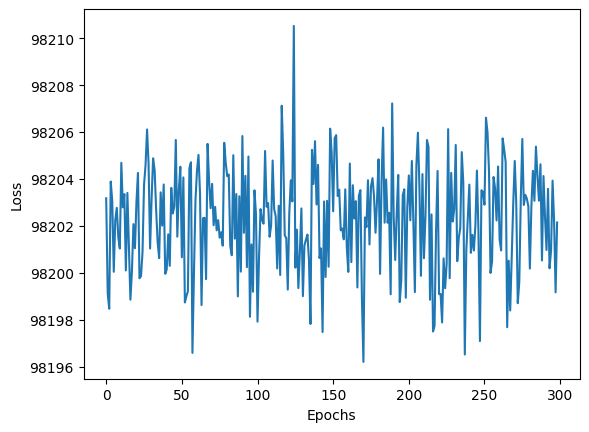

In [15]:
plt.plot(model_loss[1:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.yscale('log')
plt.plot()

In [16]:
HR, LR = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [17]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

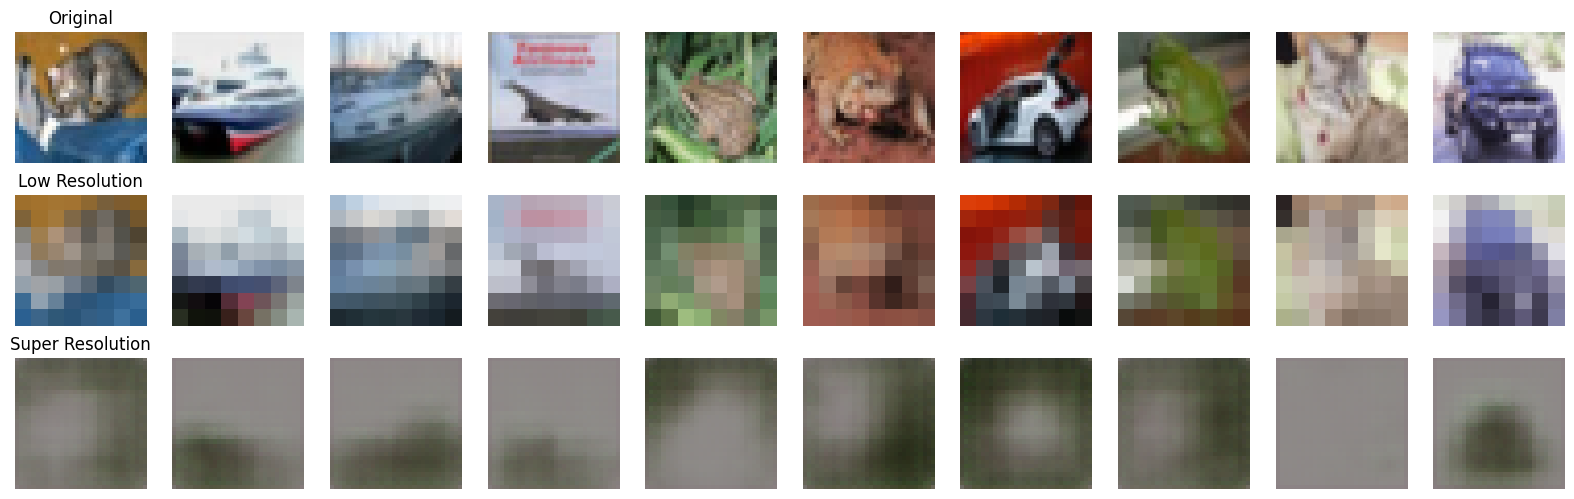

In [18]:
show_image(HR, LR, SR, 10)

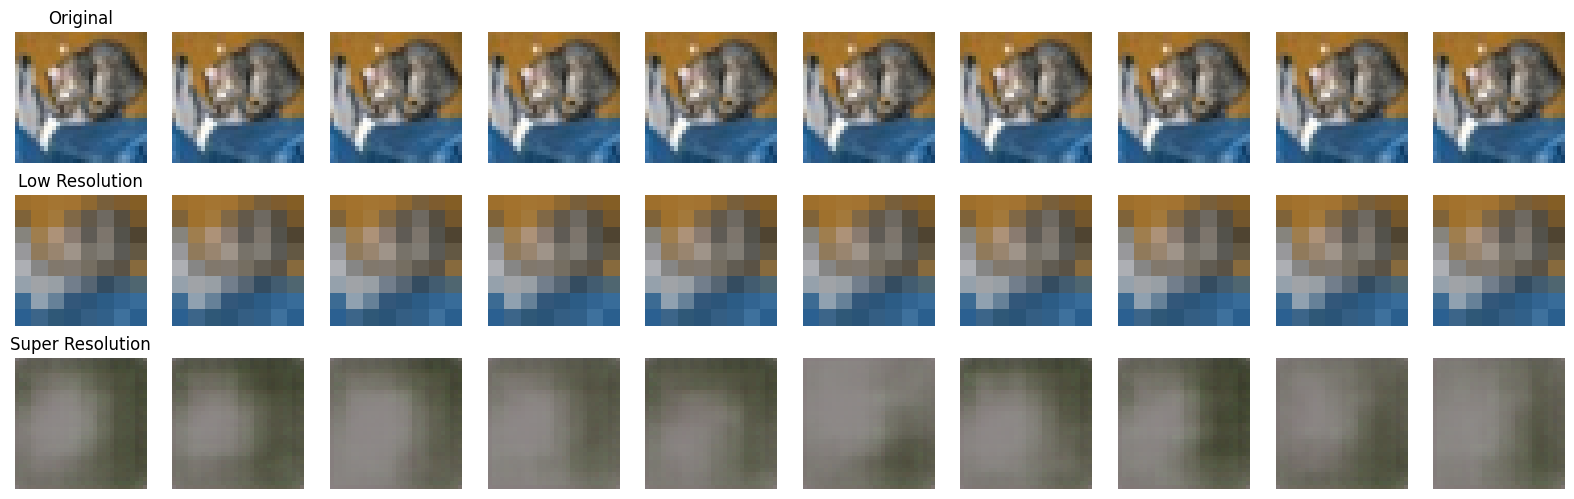

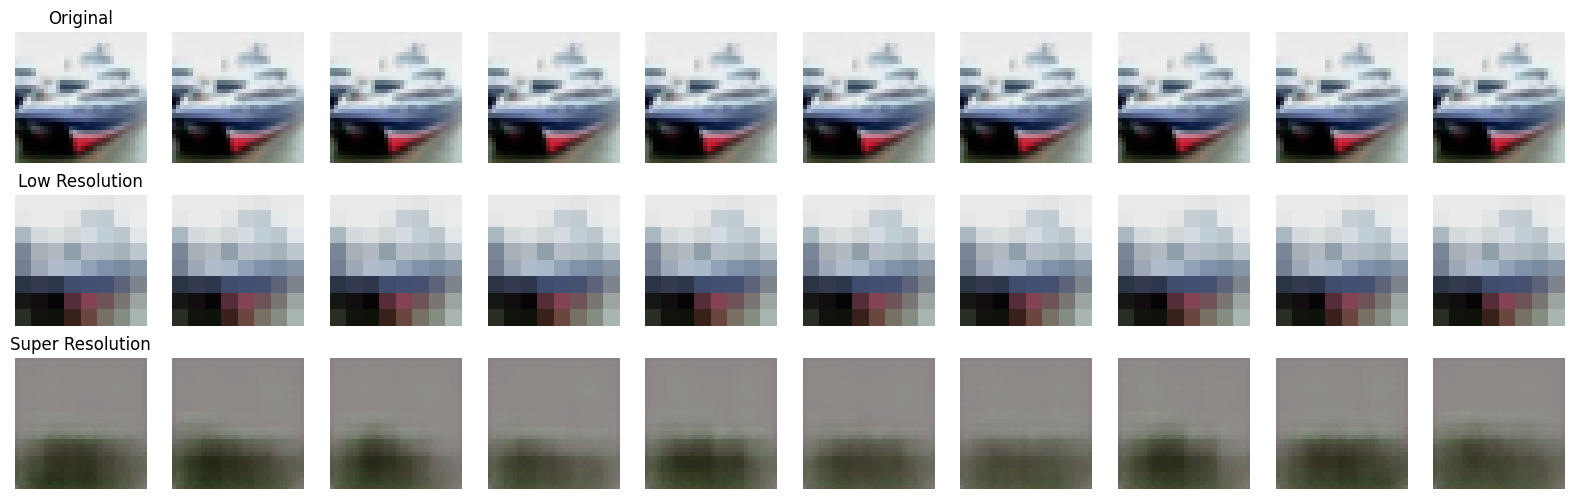

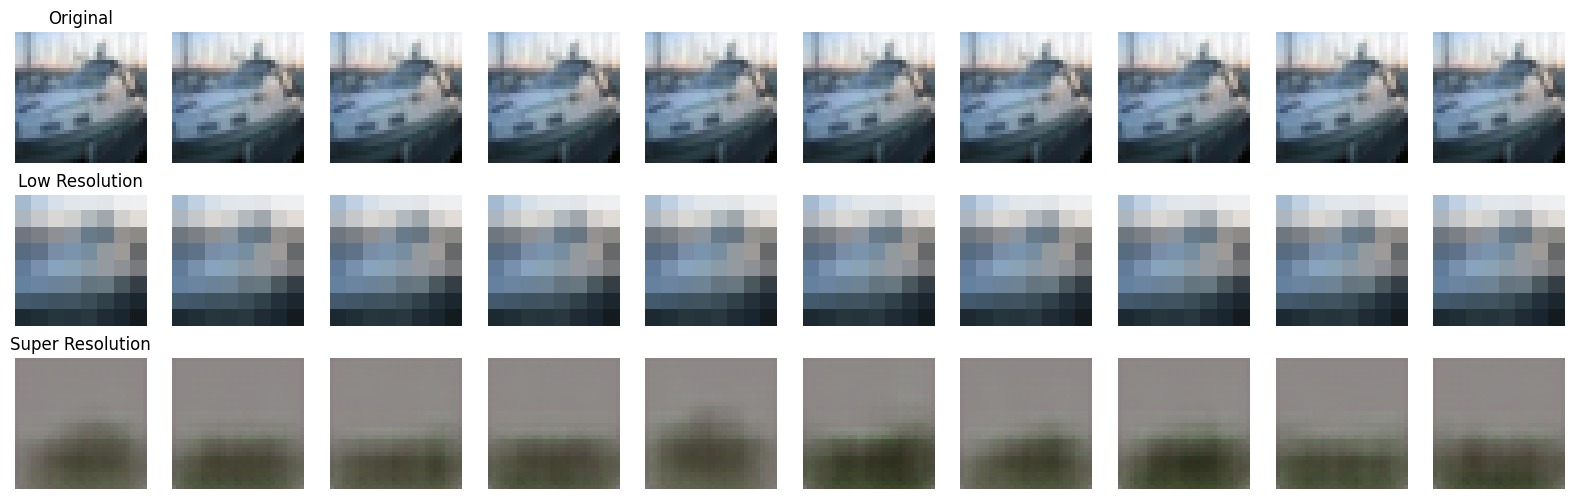

In [11]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [12]:
# save model
torch.save(model.state_dict(), path)

In [13]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [14]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.04246836155653
Perceptual: 7.504969120025635
PSNR: 14.439972877502441
SSIM: 0.19120581448078156
LPIPS: 0.7155017256736755
BRISQUE: 53.46392822265625
PSNR Consistency: 16.699966430664062
MSE Diversity: 0.0017314176596414654
LPIPS Diversity: 0.11810420345136663
